# Predicting location of hyperbolas Instance Segmentation

In this Notebook it is the same case as in the Notebook **4 Predicting_location_of_hyperbolas_Object_Detection** but that the model used is a instance segmentation Model.

- Chapter 1: Load Yolo Model
- Chapter 2: Predicting Locations of Hyperbolas with YOLO Model
- Chapter 3: Extracting Bounding Boxes and Polygons
- Chapter 4: Create a file out of the Predictions and Convert the Predictions to 3D
- Chapter 5: Implementation in Pipeline



### Chapter 1: Load Yolo Model

following code shows loading a Yolo Model directly threw the **ultralytics** Library.

In [1]:
#import libraries
import numpy as np
from ultralytics import YOLO

#Setting Working directory
import sys
from pathlib import Path

sys.path.append(str(Path.cwd().parent))

#Import the config file so that only the Filename needs to be changed in the _read_segy function
from config import *




In [2]:
#Load trained Model for Object Detection
model = YOLO(YOLO_MODEL_SEG_H_DIR)


Load the Datatoolkit and create Test Images if wanted via the Datatoolkit. Option 2 is to use the Test set of Roboflow.

In [4]:
from Pipeline.Datatoolkit import DatatoolKit

dk1 = DatatoolKit(TEST_FILE_DIR , "EG-3D QUER001.SGY")
dk2 = DatatoolKit(TEST_FILE_DIR , "UG3DQUERUNTERZUG.SGY")
file1 = dk1.LoadSGY()
file2 = dk2.LoadSGY()
df1 = dk1.create_df(file1)
df2 = dk2.create_df(file2)

In [ ]:
#dk1.create_random_test_images(df=df1,file=file1,outdir=TEST_PIC_DIR,test_inline_random=True,number_random_inlines=2)

dk2.create_random_test_images(df=df2,file=file2,outdir=TEST_PIC_DIR,test_inline_random=True,number_random_inlines=10)

saved 10 images to c:\vscode\PAINDGPR\Data\Testdata\pictures


In [4]:
dk2.create_images(file=file2, df= df2, outdir=TEST_PIC_DIR, inline=True)

saved 60 images to c:\pythonad\PAINDHS25\PAINDGPR\Data\Testdata\pictures\UG3DQUERUNTERZUG.SGY_inline_60.png


## Chapter 2: Predicting Locations of Hyperbolas with YOLO Model

In [3]:
results = model.predict(TEST_PIC_DIR,save =True, conf=0.4, show_boxes = True)


image 1/60 c:\vscode\PAINDGPR\Data\Testdata\pictures\UG3DQUERUNTERZUG.SGY_inline_1.png: 384x640 10 hyperbolas, 161.0ms
image 2/60 c:\vscode\PAINDGPR\Data\Testdata\pictures\UG3DQUERUNTERZUG.SGY_inline_10.png: 384x640 10 hyperbolas, 142.7ms
image 3/60 c:\vscode\PAINDGPR\Data\Testdata\pictures\UG3DQUERUNTERZUG.SGY_inline_11.png: 384x640 15 hyperbolas, 107.6ms
image 4/60 c:\vscode\PAINDGPR\Data\Testdata\pictures\UG3DQUERUNTERZUG.SGY_inline_12.png: 384x640 13 hyperbolas, 99.2ms
image 5/60 c:\vscode\PAINDGPR\Data\Testdata\pictures\UG3DQUERUNTERZUG.SGY_inline_13.png: 384x640 15 hyperbolas, 82.4ms
image 6/60 c:\vscode\PAINDGPR\Data\Testdata\pictures\UG3DQUERUNTERZUG.SGY_inline_14.png: 384x640 14 hyperbolas, 85.6ms
image 7/60 c:\vscode\PAINDGPR\Data\Testdata\pictures\UG3DQUERUNTERZUG.SGY_inline_15.png: 384x640 13 hyperbolas, 105.4ms
image 8/60 c:\vscode\PAINDGPR\Data\Testdata\pictures\UG3DQUERUNTERZUG.SGY_inline_16.png: 384x640 12 hyperbolas, 83.9ms
image 9/60 c:\vscode\PAINDGPR\Data\Testdata\

here is a Prediction of the Segmentation Model. \
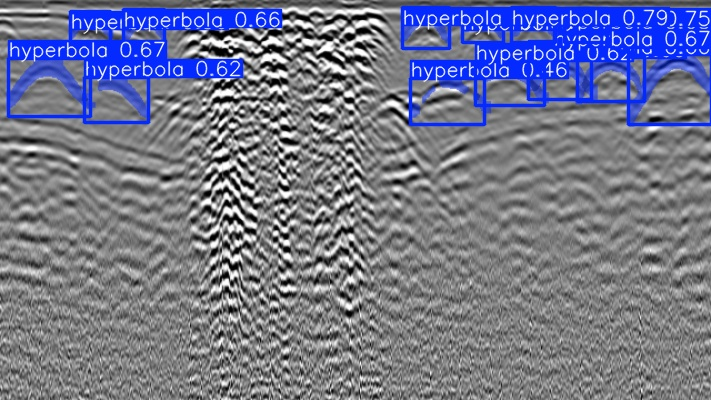

## Chapter 3: Extracting Bounding Boxes and Polygons

Now modifying the Function which was created in **4 Predicting_location_of_hyperbolas_Object_Detection.ipynb** and adjust it so it can extract the polygons and bounding boxes.

In [8]:
import os
import numpy as np

def extract_boxes_and_polygons(results)-> dict:
    
    all_results = {}

    for result in results:
        img_name = os.path.basename(result.path)
        data = {}
        if result.boxes is not None:
            data["boxes"] = result.boxes.xyxy.cpu().numpy()
            data["conf"] = result.boxes.conf.cpu().numpy()
            
        else:
            data["boxes"] = np.empty((0,4)) 
            data["conf"] = np.empty((0,))      
        
        if hasattr(result, "masks") and result.masks is not None:
            print("found polys")
            polygons = [mask.xy[0].tolist() for mask in result.masks]
            data["polygons"] = polygons
            
        
        else:
            data["polygons"] = []

        all_results[img_name] = data
    return all_results

In [5]:
preds = extract_boxes_and_polygons(results)
print(preds)

found polys
found polys
found polys
found polys
found polys
found polys
found polys
found polys
found polys
{'EG-3D QUER001.SGY_inline_15.png': {'boxes': array([[     396.41,      50.695,       471.7,      114.78],
       [      437.5,      156.54,      505.19,      229.03],
       [     1866.5,      155.15,      1965.5,      250.02],
       [     1735.2,      46.499,      1817.3,       111.1]], dtype=float32), 'conf': array([     0.5658,     0.56179,      0.5484,     0.51444], dtype=float32), 'polygons': [[[393.8343505859375, 54.90312576293945], [393.8343505859375, 92.9046859741211], [404.19842529296875, 92.9046859741211], [411.1077880859375, 85.99530792236328], [414.5625, 85.99530792236328], [418.0171813964844, 82.5406265258789], [421.47186279296875, 82.5406265258789], [424.9265441894531, 79.0859375], [428.3812255859375, 79.0859375], [431.8359375, 75.6312484741211], [435.2906188964844, 75.6312484741211], [445.6546630859375, 85.99530792236328], [449.109375, 85.99530792236328], [456.01

### Chapter 4: Create a file out of the Predictions and Convert the Predictions to 3D

Goal is to create a  CSV File which contains all bounding boxes which are index so as all polygons which are inheritend by those bounding boxes. The Challenge here is to that there has to be created a relationship betweend the images. Starting point is to define how the Structure of the CSV File should look like.

The Structure looks like the following:
|filename|cut_type|cut_number|bbox_number|bbox_data|polygon_data|
|-|-|-|-|-|-|
|file1|inline|1|1|[20,30,40,50]|Ponits of polygon in bbox|

to recreate the structure the extracting function from **Chapter 3** needs to be adjusted.

In [4]:
import os
import numpy as np
import re
import pandas as pd
import json

def match_detections(results, dist_trheshhold, out_path, export:bool = False)-> dict:
    global_boxes = []
    global_id = 0
    records = []

    def center_bbox(box):
        x1,y1,x2,y2 = box
        return ((x1+x2)/2, (y1+y2)/2)
    
    def euclidan_distance(c1, c2):
        return np.sqrt((c1[0]-c2[0])**2 + (c1[1]-c2[1])**2)
    
    def parse_filename(filename):
        base_name = os.path.basename(filename)
        
        #getting everything until SGY
        match_main = re.match(r"(.+?\.SGY)", base_name, re.IGNORECASE)
        filename_part = match_main.group(1) if match_main else base_name

        #getting cut_type and cut_number
        match_suffix = re.search(r"_(\w+)[_-](\d+)", base_name)
        cut_type = match_suffix.group(1) if match_suffix else "unknown"
        cut_number = int(match_suffix.group(2)) if match_suffix else -1

        return filename_part, cut_type, cut_number



    for result in results:
        img = os.path.basename(result.path)
        filename, cut_type, cut_number = parse_filename(img)

        if result.boxes is not None:
            boxes = result.boxes.xyxy.cpu().numpy()
           
        else:
            boxes = np.empty((0,4)) 
                  
        
        if hasattr(result, "masks") and result.masks is not None:
            polygons = [mask.tolist() for mask in result.masks.xy]
            
        else:
            polygons = []

        for i, box in enumerate(boxes):
            center = center_bbox(box)
            existing_id = None

            for gid, gcenter in global_boxes:
                if euclidan_distance(center, gcenter)< dist_trheshhold:
                    existing_id = gid
                    break
            
            if existing_id is None:
                existing_id = global_id
                global_boxes.append((global_id,center))
                global_id +=1

            polygon_data = json.dumps(polygons[i] if i < len(polygons) else [])
            bbox_data = json.dumps(box.tolist())
            

            records.append({
                "filename": filename,
                "cut_type": cut_type,
                "cut_number": cut_number,
                "bbox_number": existing_id,
                "bbox_data": bbox_data,
                "polygon_data": polygon_data
            })

    df = pd.DataFrame(records)
    if export:
        df.to_csv(f"{out_path}/results.csv")
       
    return df

Next step is to test the function

In [5]:
matched_detections = match_detections(results= results, dist_trheshhold=10, out_path=OUT_PATH_Detections, export=True )

In [6]:
matched_detections

,filename,cut_type,cut_number,bbox_number,bbox_data,polygon_data
0,UG3DQUERUNTERZUG.SGY,inline,1,0,"[564.8929443359375, 9.323530197143555, 606.538...","[[575.4656372070312, 11.140625], [575.46563720..."
1,UG3DQUERUNTERZUG.SGY,inline,1,1,"[119.51518249511719, 7.599554538726807, 165.42...","[[133.3125, 6.696875095367432], [133.3125, 11...."
2,UG3DQUERUNTERZUG.SGY,inline,1,2,"[512.0293579101562, 8.925403594970703, 553.642...","[[522.140625, 11.140625], [522.140625, 14.4734..."
3,UG3DQUERUNTERZUG.SGY,inline,1,3,"[457.6700439453125, 9.530699729919434, 501.564...","[[469.92657470703125, 11.140625], [469.9265747..."
4,UG3DQUERUNTERZUG.SGY,inline,1,4,"[520.1708374023438, 60.12672805786133, 594.235...","[[543.2484130859375, 60.02187728881836], [543...."
...,...,...,...,...,...,...
738,UG3DQUERUNTERZUG.SGY,inline,9,15,"[467.36358642578125, 59.840248107910156, 542.1...","[[488.8125, 60.02187728881836], [488.8125, 63...."
739,UG3DQUERUNTERZUG.SGY,inline,9,10,"[277.7679748535156, 11.377154350280762, 317.78...","[[287.7328186035156, 11.140625], [287.73281860..."
740,UG3DQUERUNTERZUG.SGY,inline,9,6,"[574.64453125, 56.79171371459961, 639.83074951...","[[595.4625244140625, 55.578125], [595.46252441..."
741,UG3DQUERUNTERZUG.SGY,inline,9,5,"[399.19329833984375, 9.326850891113281, 444.06...","[[411.046875, 11.140625], [411.046875, 15.5843..."


looks promising with respect to the Dataframme. But for better intepreatation a plot is needed and if its matching with the detections from YOLO.

In [41]:
import pandas as pd
import json
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm
def plot_matched_detections(df, csv:bool=False, csv_path:str = None):

    if csv:
        df = pd.read_csv(csv_path)
    else:
        df = df

    fig = plt.figure(figsize=(10,8))
    ax = fig.add_subplot(projection='3d')

    for i, row in df.iterrows():

        cut_number = row["cut_number"]
        polys = row["polygon_data"]
        bbox_number = row["bbox_number"]

        try:
            polygon = json.loads(polys)
        
        except json.JSONDecodeError:
            continue

        if not polygon or not isinstance(polygon[0], (list, tuple)):
            continue
        
        xs = [p[0] for p in polygon]
        zs = [p[1] for p in polygon]
        ys = [cut_number]

        color = cm.tab20(int(bbox_number)%20)
        ax.plot(xs, ys, zs, color = color, linewidth = 0.8,alpha = 0.5)

    ax.set_xlim(0,711)
    ax.set_zlim(0,400)
    ax.set_xlabel("X Values Polygons")
    ax.set_ylabel("Cut_number")
    ax.set_zlabel("Y Values Polygons")
    ax.invert_zaxis()

    ax.set_title("3D Plot of Detections")

    plt.show()



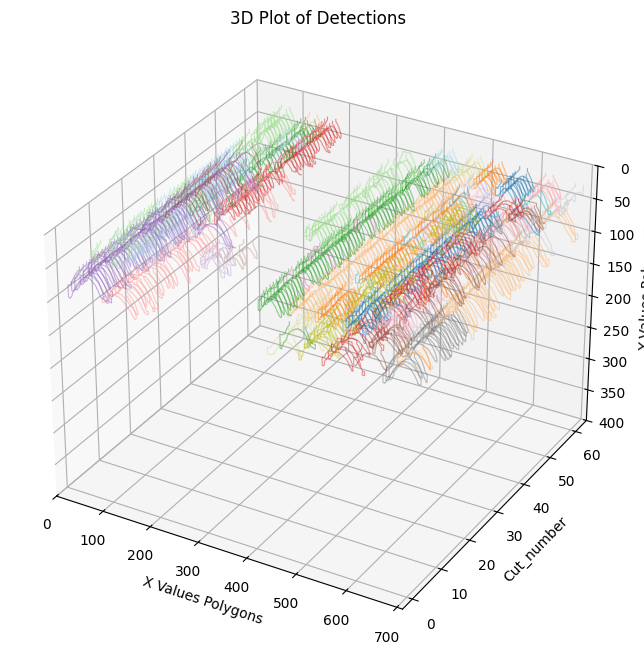

In [ ]:
plot_matched_detections(df=matched_detections)

out of the first plot its not realy clear which hyperbolas are on which inline so the next plot adds those spheres.

In [45]:
import pandas as pd
import json
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm
def plot_matched_detections(df, csv:bool=False, csv_path:str = None):

    xlim = (0,711)
    zlim = (0,400)

    if csv:
        df = pd.read_csv(csv_path)
    else:
        df = df

    fig = plt.figure(figsize=(15,15))
    ax = fig.add_subplot(projection='3d')
    ax.set_box_aspect([1,1,1])

    cuts = sorted(df["cut_number"].unique())
    X, Z = np.meshgrid(np.linspace(xlim[0],xlim[1],10),
                       np.linspace(zlim[0], zlim[1], 10))
    
    for cut in cuts:
        Y = np.ones_like(X) * cut
        ax.plot_surface(X, Y, Z, color="gray", alpha = 0.02, linewidth = 0.3)



    for i, row in df.iterrows():

        cut_number = row["cut_number"]
        polys = row["polygon_data"]
        bbox_number = row["bbox_number"]

        try:
            polygon = json.loads(polys)
        
        except json.JSONDecodeError:
            continue

        if not polygon or not isinstance(polygon[0], (list, tuple)):
            continue
        
        xs = [p[0] for p in polygon]
        zs = [p[1] for p in polygon]
        ys = [cut_number]

        color = cm.tab20(int(bbox_number)%20)
        ax.plot(xs, ys, zs, color = color, linewidth = 0.9,alpha = 0.8,
                label= f"Bounding Box {int(bbox_number)}")

    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys(), title="Bounding Boxes", loc="upper left",
              bbox_to_anchor = (0, 0., 0.5, 1),
              framealpha = 0.0, fontsize = 7)

    ax.set_xlim(xlim[0], xlim[1])
    ax.set_zlim(zlim[0], zlim[1])
    ax.set_xlabel("X Values Polygons = Crosslines")
    ax.set_ylabel("Inline")
    ax.set_zlabel("Y Values Polygons = Time Sample")
    ax.invert_zaxis()

    ax.set_title("3D Plot of Detections")

    plt.show()



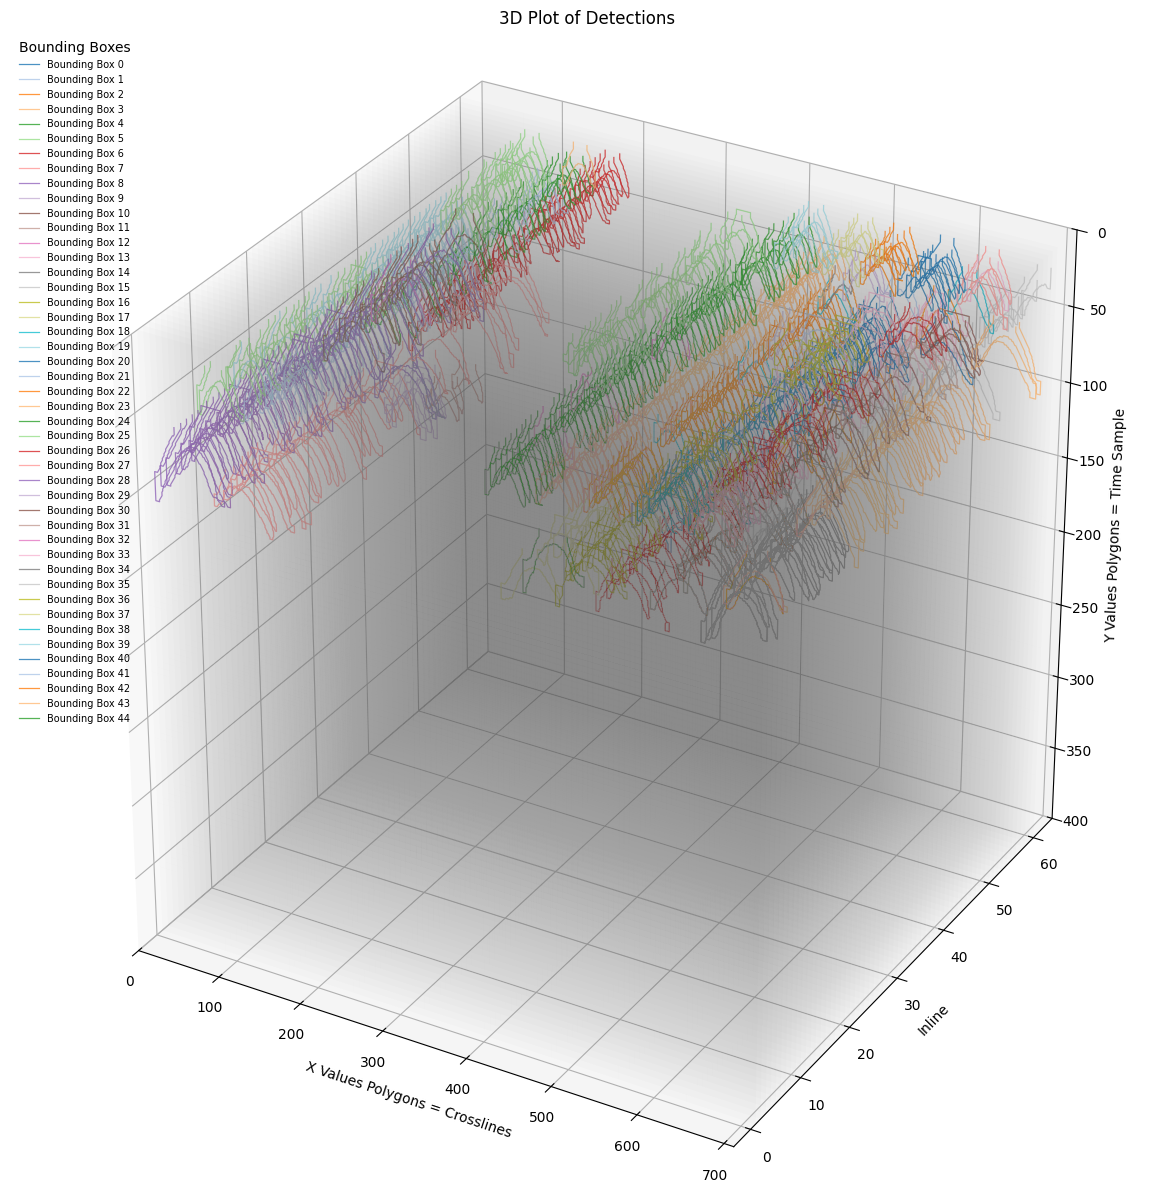

In [ ]:
plot_matched_detections(df = matched_detections)

This looks better but still there has to be a way to see if all detections are displayed in the csv and the plot. sot the next step is to create a function which compares the number of polygons in the csv or Dataframe with the number of detections from YOLO.

In [38]:
def validate_detections(matched_detections,results, csv:bool = False, csv_path:str = None):

    if csv:
        matched_df = pd.read_csv(csv_path, sep=",")
    else:
        matched_df = matched_detections

    number_detections_csv_total = matched_df.shape[0]
    number_of_detections_results = 0

    for result in results:
        if result.masks.xy is not None:
            number_of_detections_results += len(result.masks.xy)

    if number_detections_csv_total == number_of_detections_results:
        print("Detections YOLO matching with Matched Detections")
    
    else:
        print(f"Yolo Detections:{number_of_detections_results} Number of Matched Detections {number_detections_csv_total}")

    


In [39]:
validate_detections(matched_detections=matched_detections,results=results)

Detections YOLO matching with Matched Detections


#### Fitting Hyperbolas

In [7]:
from sklearn.linear_model import LinearRegression
import pandas as pd
import numpy as np
import json

def fit_hyperbolas(df, csv:bool=False, csv_path:str = None):
    if csv:
        df = pd.read_csv(csv_path)
    else:
        df = df

    fits = []
    for i, row in df.iterrows():
        #Fit Hyperbolas with multiplie Regression
        polygon =  json.loads(row["polygon_data"])
        bbox = row["bbox_number"]
        polygon = np.array(polygon)
        x = polygon[:,0]
        t = polygon[:,1]
        t = t

        y = t**2
        X = np.column_stack([np.ones_like(x), x, x**2])
        model = LinearRegression(fit_intercept=False)
        model.fit(X,y)

        print(f"polygon:{i} in bbox:{bbox} , coefficients{model.coef_}")
        b0, b1, b2 = model.coef_

        #Convert Coefficients to Hyperbel context
        v = np.sqrt((4/b2))
        x0 = (-b1) / (2*b2)
        t0 = np.sqrt(b0 -b1**2 / ( 4*b2))

        fits.append({
            "filename": row["filename"],
            "cut_number": row["cut_number"],
            "bbox_number":row["bbox_number"],
            "b0_Model": b0,
            "b1_Model": b1,
            "b2_Model": b2,
            "v":v,
            "x0":x0,
            "t0":t0,
            "X_Data":x,
            "t_data":t
        })
    
    fits_df = pd.DataFrame(fits)
    return fits_df




    

In [8]:
fits = fit_hyperbolas(df=matched_detections)

polygon:0 in bbox:0 , coefficients[ 6.7336e+05     -2295.5      1.9574]
polygon:1 in bbox:1 , coefficients[      35976     -496.32      1.7291]
polygon:2 in bbox:2 , coefficients[ 4.1882e+05     -1573.1      1.4785]
polygon:3 in bbox:3 , coefficients[ 3.3732e+05     -1397.2      1.4485]
polygon:4 in bbox:4 , coefficients[ 1.3456e+06     -4804.4      4.3026]
polygon:5 in bbox:5 , coefficients[ 3.4685e+05     -1626.1      1.9077]
polygon:6 in bbox:6 , coefficients[ 1.4043e+06     -4583.9      3.7522]
polygon:7 in bbox:7 , coefficients[      14973     -326.53      1.8303]
polygon:8 in bbox:8 , coefficients[ 4.9719e+05     -1409.9      1.0002]
polygon:9 in bbox:9 , coefficients[ 1.8842e+06     -5551.2      4.0963]
polygon:10 in bbox:2 , coefficients[ 5.6214e+05     -2119.6      1.9986]
polygon:11 in bbox:4 , coefficients[ 9.5162e+05       -3402      3.0556]
polygon:12 in bbox:5 , coefficients[ 3.5963e+05     -1702.2      2.0161]
polygon:13 in bbox:1 , coefficients[      47702     -652.07  

In [23]:
fits

,filename,cut_number,bbox_number,b0_Model,b1_Model,b2_Model,v,x0,t0,X_Data,t_data
0,UG3DQUERUNTERZUG.SGY,1,0,8.442127e+05,-2882.937146,2.462008,1.274633,585.484884,15.957393,"[576.5765380859375, 576.5765380859375, 574.354...","[11.140625, 14.473437309265137, 16.6953125, 17..."
1,UG3DQUERUNTERZUG.SGY,1,1,3.538484e+04,-489.941519,1.715070,1.527176,142.834296,19.864918,"[131.0906219482422, 131.0906219482422, 129.979...","[11.140625, 15.584375381469727, 16.6953125, 17..."
2,UG3DQUERUNTERZUG.SGY,1,2,5.348509e+05,-2005.609289,1.881369,1.458119,533.018594,18.367157,"[522.140625, 522.140625, 518.8078002929688, 51...","[11.140625, 15.584375381469727, 18.91718864440..."
3,UG3DQUERUNTERZUG.SGY,1,3,4.141376e+05,-1716.111747,1.779367,1.499330,482.225242,19.009206,"[471.0375061035156, 471.0375061035156, 469.926...","[11.140625, 14.473437309265137, 15.58437538146..."
4,UG3DQUERUNTERZUG.SGY,1,4,3.676710e+05,-1728.257564,2.032850,1.402741,425.082501,18.572397,"[413.26873779296875, 413.26873779296875, 411.0...","[11.140625, 14.473437309265137, 16.6953125, 17..."
...,...,...,...,...,...,...,...,...,...,...,...
668,UG3DQUERUNTERZUG.SGY,9,13,1.301196e+06,-3870.321342,2.886796,1.177123,670.349006,62.951594,"[657.6749877929688, 657.6749877929688, 647.676...","[51.134376525878906, 54.46718978881836, 64.465..."
669,UG3DQUERUNTERZUG.SGY,9,8,1.036686e+04,-245.946213,2.882278,1.178045,42.665244,71.555446,"[31.106250762939453, 31.106250762939453, 17.77...","[60.02187728881836, 63.35468673706055, 76.6859..."
670,UG3DQUERUNTERZUG.SGY,9,3,5.608178e+05,-2334.970473,2.431712,1.282549,480.108280,17.274949,"[473.2593688964844, 473.2593688964844, 472.148...","[11.140625, 15.584375381469727, 16.6953125, 17..."
671,UG3DQUERUNTERZUG.SGY,9,4,4.462224e+05,-2121.674407,2.523658,1.258968,420.356927,17.091084,"[412.1578063964844, 412.1578063964844, 408.825...","[11.140625, 14.473437309265137, 17.80624961853..."


In [49]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from matplotlib.cm import get_cmap

def plot_hyperbolas_3d(fits_df):
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Jeder bbox_number bekommt konstante Farbe
    bbox_ids = sorted(fits_df["bbox_number"].unique())
    cmap = get_cmap("tab20")
    color_map = {bbox: cmap(i % 20) for i, bbox in enumerate(bbox_ids)}

    for idx, row in fits_df.iterrows():
        x = row["X_Data"]
        t = row["t_data"]
        y = np.full_like(x, row["cut_number"])  # Cut-Nummer als y-Achse
        bbox = row["bbox_number"]
        v = row["v"]
        x0 = row["x0"]
        t0 = row["t0"]
        color = color_map[bbox]

        # Hyperbel erzeugen
        x_fit = x
        t_fit = np.sqrt((4/v**2) * (x_fit - x0)**2 + t0**2)
        y_fit = np.full_like(x_fit, row["cut_number"])

        # Polygonpunkte
        #ax.scatter(x, y, t, color=color, s=10)

        # Gefittete Hyperbel
        ax.plot(x_fit, y_fit, t_fit, color=color, linewidth=2)

        # Apex
        ax.scatter([x0], [row["cut_number"]], [t0],
                   color=color, marker="x", s=80)

    ax.set_xlabel("x (Pixel)")
    ax.set_ylabel("cut_number (Inline / y-Richtung)")
    ax.set_zlabel("t (inverted Pixel/Time)")

    ax.invert_zaxis()  # damit Zeit nach unten größer wird (GPR-like)

    plt.title("3D Hyperbel-Fits (Hyperbolic Cylinder)")
    plt.show()


C:\Users\gijo\AppData\Local\Temp\ipykernel_26336\999500307.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap("tab20")


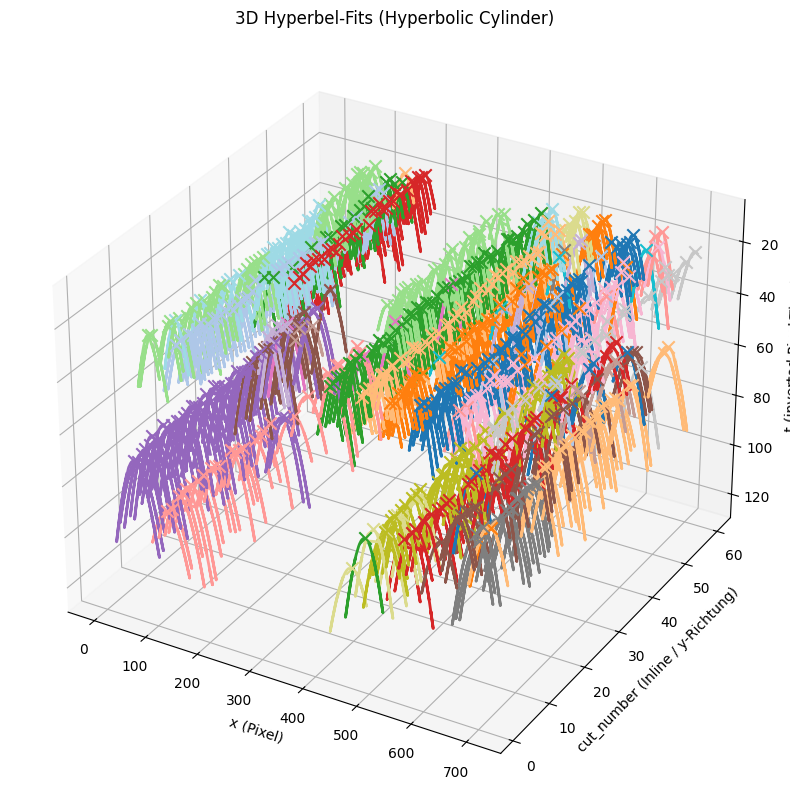

In [50]:
plot_hyperbolas_3d(fits)

### Interactive Plots

In [9]:
import plotly.io as pio
pio.renderers.default = "browser"

import plotly.graph_objects as go
import numpy as np
import json
from matplotlib.cm import get_cmap

def plot_hyperbolas_3d_interactive(fits_df, matched_detections):

    fig = go.Figure()
    cmap = get_cmap("tab20")

    traces_hyper = []
    traces_apex  = []
    traces_poly  = []

    # -------------------- HYPERBELN + APEX --------------------
    for _, row in fits_df.iterrows():

        bbox = int(row["bbox_number"])
        cut  = int(row["cut_number"])
        X    = np.array(row["X_Data"])
        v, x0, t0 = row["v"], row["x0"], row["t0"]

        r,g,b,a = cmap(bbox % 20)
        col = f"rgba({255*r:.0f},{255*g:.0f},{255*b:.0f},{a})"

        # Hyperbel
        xf = np.linspace(X.min(), X.max(), 150)
        yf = np.full_like(xf, cut)
        tf = np.sqrt((4/v**2)*(xf-x0)**2 + t0**2)

        traces_hyper.append(len(fig.data))
        fig.add_trace(go.Scatter3d(
            x=xf, y=yf, z=tf,
            mode="lines",
            line=dict(color=col, width=4),
            showlegend=False,
            visible=True
        ))

        # Apex
        traces_apex.append(len(fig.data))
        fig.add_trace(go.Scatter3d(
            x=[x0], y=[cut], z=[t0],
            mode="markers",
            marker=dict(size=5, color=col),
            showlegend=False,
            visible=False
        ))

    # -------------------- POLYGONE --------------------
    for _, row in matched_detections.iterrows():

        bbox = int(row["bbox_number"])
        cut  = int(row["cut_number"])

        try:
            poly = json.loads(row["polygon_data"])
        except:
            continue

        xs = [p[0] for p in poly]
        zs = [p[1] for p in poly]
        ys = [cut] * len(xs)

        if len(xs) < 2:
            continue

        r,g,b,a = cmap(bbox % 20)
        col = f"rgba({255*r:.0f},{255*g:.0f},{255*b:.0f},{a})"

        traces_poly.append(len(fig.data))
        fig.add_trace(go.Scatter3d(
            x=xs, y=ys, z=zs,
            mode="lines",
            line=dict(color=col, width=3),
            showlegend=False,
            visible=False
        ))

    # -------------------- Typ-Filterfunktionen --------------------
    def mask(traces):
        vis = [False]*len(fig.data)
        for t_id in traces:
            vis[t_id] = True
        return vis

    # -------------------- Buttons --------------------
    fig.update_layout(
        updatemenus=[
            dict(
                type="buttons",
                direction="right",
                x=0.05,
                y=1.15,
                buttons=[
                    dict(label="Hyperbeln", method="update", args=[{"visible": mask(traces_hyper)}]),
                    dict(label="Apex",      method="update", args=[{"visible": mask(traces_apex)}]),
                    dict(label="Polygone",  method="update", args=[{"visible": mask(traces_poly)}]),
                ]
            )
        ],
        scene=dict(
            xaxis=dict(range=[0,720]),
            yaxis=dict(range=[0, matched_detections["cut_number"].max()]),
            zaxis=dict(range=[400,0], autorange=False)
        ),
        height=850,
        title="Hyperbeln / Apex / Polygone – einfacher Umschalter"
    )

    fig.show()


In [10]:
plot_hyperbolas_3d_interactive(fits,matched_detections)

C:\Users\gijo\AppData\Local\Temp\ipykernel_14804\479367034.py:12: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



### Chapter 4: Implementation in Pipeline

We can now implement the **ectract_boxes_and_polygons()** which is a update to the **extract_boxes()** to the **Predictor Class**. Now we can make Predictions on diffrent Model types and extract the relevant information for the type of model. Here the two types which where tested are **Object Detection** and **Instance Segmentation**